In [1]:
from random import randint
from collections import defaultdict
from uuid import uuid4
from dataclasses import dataclass
from datetime import datetime
from time import sleep
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipynb.fs.full.Observer import RemoteCamera, CaptureMachine, TrackedObject, CaptureConfiguration, \
    Camera, hStackImages, vStackImages, cameras, ChangeSet, RealSpaceConverter
import dma.MechaCombat as mc
QuantumSystem = mc.QuantumSystem

In [2]:
from ultralytics import YOLO
DiceWatcher = YOLO("diceWatcher.pt")

In [3]:
@dataclass
class QuantumObject(TrackedObject):
    name: str
    objectType: str

    def __eq__(self, other):
        return super().__eq__(other)

    def __repr__(self):
        changeSet = {camNum: cS for camNum, cS in self.changeSet.items() if cS is not None and cS.changeType not in [None, 'delete']}
        return f"QO - {self.objectType} - {self.name} ({changeSet})"
    
    def __post_init__(self):
        super().__post_init__()
        self.qid = str(uuid4())
        self.actionHistory = {}

    def previousVersion(self):
        return type(self)({camNum: change.lastChange if change is not None else None for camNum, change in self.changeSet.items()}, self.name, self.objectType)

    def commitAction(self, cycleNumber, newAction):
        self.actionHistory[cycleNumber] = newAction

In [4]:
@dataclass
class HarmonyCamera(RemoteCamera):
    camType: str = "field"

    knownCameraTypes = ["field", "dice"]
    
    def collectDiceRoll(self):
        assert self.camType == "dice", "Only dice cameras can collect dice rolls"
        src = self.cropToActiveZone(self.collectImage())
        res = DiceWatcher(src, conf=0.65)[0]
        recs = [box.cls.item() + 1 for box in res.boxes]
        assert len(recs) in [0, 2], f"Unable to distinguish 0 or 2 dice; Saw {len(recs)}"
        return sum([box.cls.item() + 1 for box in res.boxes])

In [5]:
class HarmonyConfiguration(CaptureConfiguration):
    def capture(self):
        self.lastCapture = {cam.camName: cam.capture() for cam in cameras.values() if cam is not None and cam.camType == 'field'}
        return self.lastCapture

    def collectDiceRoll(self):
        diceCam = [cam for cam in cameras.values() if cam.camType == "dice"][0]
        return diceCam.collectDiceRoll()

    def loadConfiguration(self):
        try:
            with open("observerConfiguration.json", "r") as f:
                config = json.loads(f.read())
        except:
            print("Failed to open Observer Configuration!")
            ## TODO: Default configuration if file not found
            raise

        for camName, camDef in config.items():
            if str(camName) in ["pov", "dice"]:
                global pov
                addr = camDef['addr']
                rot = camDef['rot']
                pov = HarmonyCamera(address=addr, rotate=rot, activeZone=[], camName="pov", camType="dice")
            elif str(camName) == "rsc":
                if camDef is None:
                    continue
                else:
                    self.rsc = [
                        [cN, [[np.array(pt, dtype="int32") for pt in cL] for cL in coordList]]
                        for cN, coordList in camDef]
                    self.rsc = RealSpaceConverter(self.rsc)
            elif str(camName) == "calibrationPlan":
                self.calibrationPlan = camDef
            else:
                addr = camDef['addr']
                rot = camDef['rot']
                az = np.float32(json.loads(camDef['az']))
                ct = camDef.get('camType', 'field')
                cameras[camName] = HarmonyCamera(address=addr, activeZone=az, camName=camName, camType=ct)
    
    def jsonConfiguration(self):
        state = {
            camName: {
                "addr": cam.address,
                "rot": cam.rotate,
                "az": json.dumps(cam.activeZone.tolist()),
                "camType": cam.camType}
            for camName, cam in cameras.items()}
        if self.rsc is not None:
            state["rsc"] = [[cN, [[a.tolist() if type(a) != list else a for a in coordList[0]], [a.tolist() if type(a) != list else a for a in coordList[1]]]]
                            for cN, coordList in self.rsc.realCamSpacePairs]
        else:
            state["rsc"] = None
        state["calibrationPlan"] = self.calibrationPlan
        return json.dumps(state, indent=2)

In [6]:
class HarmonyMachine(CaptureMachine):
    states = ["idle", "unstable", "classify", "illegal"]
    modes = ["passive", "calibrate", "add", "move", "action"]
    actionStates = ["sel0", "sel1", "confirm", "roll"]
    MM_FOR_MOVE = 15

    def __init__(self, config: HarmonyConfiguration):
        super().__init__(config)
        self.hc = self.cc
        mc.qs.reset()
        factory = mc.ObjectFactories["Huntsman"]
        factory("Initializer", "Unaligned")
        self.newObjectBuffer = []
        self.selectedObjects = []
        self.mode = "passive"
        self.actionState = "sel0"
        self.diceRoll = None
        self.realSpaceContours = None
        
    def referenceFrameDeltas(self):
        return ChangeSet({camName: cam.referenceFrameDelta() for camName, cam in cameras.items() if cam.camType == 'field'})
    
    def isLegal(self, classifiedChange):
        return True
        
    def storeNewObject(self, objDef):
        if not objDef.isNewObject:
            existingIndex = self.newObjectBuffer.index(objDef.previousVersion())
            existingObj = self.newObjectBuffer[existingIndex]
            existingObj.update(objDef, overwrite=self.cc.rsc.trackedObjectLastDistance(objDef) > self.MM_FOR_MOVE)
        else:
            self.newObjectBuffer.append(objDef)
        self.lastMemory = {"newObject": objDef}
        
        for camNum, change in objDef.changeSet.items():
            cameras[camNum].commitChange(change)
        
        self.transitions.append({
            "obj": objDef,
            "cycle": self.cycleCounter,
            "cameraChanges":  {camNum: {"ref": cam.referenceFrame, "fin": cam.mostRecentFrame}
                               for camNum, cam in cameras.items()}})
    
    def commitChanges(self, objDef):
        try:
            existingIndex = self.memory.index(objDef.previousVersion())
            existingObj = self.memory[existingIndex]
            print(f"Updating Memory {existingIndex}")
            existingObj.update(objDef, overwrite=self.cc.rsc.trackedObjectLastDistance(objDef) > self.MM_FOR_MOVE)
        except Exception:
            raise Exception("Cannot commit to unrecognized memory")
        self.lastMemory = {"changedObject": existingObj}
        
        for camNum, change in objDef.changeSet.items():
            cameras[camNum].commitChange(change)

        self.transitions.append({
            "obj": objDef,
            "cycle": self.cycleCounter,
            "cameraChanges":  {camNum: {"ref": cam.referenceFrame, "fin": cam.mostRecentFrame}
                               for camNum, cam in cameras.items()}})

    def annotateObject(self, oid, objName, objType):
        caps = {cap.oid: cap for cap in self.newObjectBuffer + self.memory}
        cap = caps[oid]
        center = self.cc.rsc.changeSetToRealCenter(cap)
        qObj = QuantumObject(cap.changeSet, objName, objType)
        factory = mc.ObjectFactories[objType]
        factory(objName, "Unaligned")
        mc.XYLocation.set_location(objName, json.dumps(list(center) + [0]))
        self.memory.append(qObj)
        self.newObjectBuffer.remove(cap)
        self.lastMemory = {"annotatedObject": qObj}

    def deleteObject(self, oid):
        newCaps = {cap.oid: cap for cap in self.newObjectBuffer}
        if oid in newCaps:
            cap = newCaps[oid]
            self.newObjectBuffer.remove(cap)
        memCaps = {cap.oid: cap for cap in self.memory}
        if oid in memCaps:
            cap = memCaps[oid]
            self.memory.remove(cap)
        self.lastMemory = {"deletedObject": oid}
        self.mode = "passive"
        
    
    def cycle(self):
        cycleStart = datetime.utcnow()
        minimumClassificationTime = 1
        try:
            print(f"Starting Cycle {self.cycleCounter:5} -- {self}" + '' if self.state != "action" else f" {self.actionState}")
            self.cycleCounter += 1
            nextState = "idle"
            self.hc.capture()
            changes = self.referenceFrameDeltas()

            if self.mode == "passive":
                self.hc.setReference()
                return
            elif self.actionState in ["confirm", "roll"]:
                # Test Legality of Attack between sO[0] -> sO[1]
                # if not legal: 
                    # self.selectedObjects = []
                    # self.actionState = "sel0"
                # Calculate SATOR for Attack
                self.targetRoll = 5
                  # Wait for confirmation by Dice Roll going to 0
                roll = self.hc.collectDiceRoll()
                if self.actionState == "confirm" and roll == 0:
                    self.actionState = "roll"
                    print(f"Waiting for dice roll: {self.actionState}")
                    self.lastMemory = {"confirmedAction": [self.targetRoll, *self.selectedObjects]}
                elif self.actionState == "roll" and roll != 0:
                    self.diceRoll = 7
                    sel0, sel1 = self.selectedObjects
                    if roll > self.targetRoll:
                        print(f"Dice roll success: {roll}")
                        sel1.commitAction(self.cycleCounter, ["hit", roll, sel0.name])
                    else:
                        print(f"Dice roll failure: {roll}")
                        sel1.commitAction(self.cycleCounter, ["missed", roll, sel0.name])
                    self.lastMemory = {"actedOn": sel1}
                    self.selectedObjects = []
                    self.actionState="sel0"
                else:
                    print(f"Waiting for confirmation: {roll}")
            # else: mode in ["calibrate", "add", "move", "attack"]
            
            classification = None
            if changes.empty and self.state == "idle":
                self.hc.setReference()
            elif not changes.empty:
                nextState = "unstable"
                if self.state in ["unstable", "classify"] and changes == self.lastChanges:  # TODO: and cameraChangeOverlap
                    classification = self.classifyChanges(changes)
                    nextState = "classify"
                    if self.state == "classify":
                        if self.mode in ["move", "action"]:
                            assert not classification.isNewObject, f"Cannot add objects in {self.mode}"
                            if self.mode == "move":
                                assert self.isLegal(classification), f"{classificaton} is an illegal move"
                            elif self.mode == "action":
                                assert (lastDist := self.cc.rsc.trackedObjectLastDistance(classification)) < self.MM_FOR_MOVE, f"{classification} moves too far ({lastDist}) for selection"
                                assert self.actionState not in ['roll'], "Gameboard changed while monitoring for dice roll"
                            
                            nextState = "idle"
                            print("Committing classification")
                            self.commitChanges(classification)
                            if self.mode == "action":
                                if len(self.selectedObjects) == 2:
                                    self.selectedObjects = [self.lastMemory["changedObject"]]
                                    self.actionState = "sel1"
                                else:
                                    self.selectedObjects.append(self.lastMemory["changedObject"])
                                    self.actionState = "sel1" if len(self.selectedObjects) == 1 else "confirm"
                                print(f"Selected Objects: {self.selectedObjects}")
                                self.lastMemory = {"selectedObject": self.lastMemory["changedObject"]}
                            self.hc.setReference()
                        elif self.mode == "add":
                            nextState = "idle"
                            self.storeNewObject(classification)
                            self.hc.setReference()
                        elif self.mode == "calibrate":
                            try:
                                self.calibrateToObject(classification)
                            except AssertionError as ae:
                                print(f"Failed Calibration: {ae}")
                            nextState = "idle"
                            self.hc.setReference()
                        else:
                            raise Exception("Unrecognized State")
                        
                    cycleEnd = datetime.utcnow()
                    if (cycleTime := (cycleEnd - cycleStart).total_seconds()) < minimumClassificationTime:
                        sleep(minimumClassificationTime - cycleTime)
            self.state = nextState
            self.lastChanges = changes
            self.lastClassification = classification
        except Exception as e:
            from traceback import format_exc
            print("CYCLE FAILURE!!!")
            print(format_exc())
            self.state = "unstable"
            self.lastChanges = None
            self.lastClassification = None
            raise
            
    def objectToHull(self, obj, color=(255, 255, 255)):
        newContour = {
            camName: np.array([
                [[self.cc.rsc.camCoordToRealSpace(camName, pt[0])]
                for cnt in cS.changeContours for pt in cnt]], dtype="int32")
            for camName, cS in obj.changeSet.items() if cS.changeType in ['add', 'move']}
    
        contourBase = np.zeros([1200, 1200], dtype="uint8")
        contourOverlap = None
        cSDeltas = self.cc.rsc.changeSetCenterDeltas(obj)
        for index, (camName, contours) in enumerate(newContour.items()):
            tx, ty = cSDeltas[camName]
            M = np.float32([[1, 0, tx], [0, 1, ty]])
            for cnt in contours:
                filledContour = cv2.drawContours(contourBase.copy(), [cnt], -1, 255, -1)
                shiftedFilledContour = cv2.warpAffine(filledContour, M, (1200, 1200))
                if contourOverlap is None:
                    contourOverlap = shiftedFilledContour
                else:
                    contourOverlap = cv2.bitwise_or(contourOverlap, shiftedFilledContour)
        contours, _ = cv2.findContours(contourOverlap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        hull = cv2.convexHull(contours[-1])
        return hull

    def buildMiniMap(self):
        image = np.zeros([1200, 1200, 3], dtype="uint8")
        try:
            if self.realSpaceContours is None:
                self.realSpaceContours = self.cc.rsc.cameraRealSpaceOverlap(cameras)
                x, y, w, h = 1200, 1200, 1, 1
                for contour in self.realSpaceContours:
                    cbX, cbY, cbW, cbH = cv2.boundingRect(contour)
                    cb_maxX = cbX + cbW
                    cb_maxY = cbY + cbH
                    x = min(x, cbX)
                    y = min(y, cbY)
                    w = max(w, cb_maxX - x)
                    h = max(h, cb_maxY - y)
                self.realSpaceBoundingBox = x, y, w, h
        except Exception as e:
            print(e)
            self.realSpaceContours = None
            return image
        x, y, w, h = self.realSpaceBoundingBox
    
        objsAndColors = \
              [[newObj, (0, 255, 255)] for newObj in self.newObjectBuffer] \
            + [[mem, (255, 0, 0)] for mem in self.memory] \
            + ([[self.lastClassification, (0, 255, 0)]] if self.lastClassification is not None and not self.lastClassification.empty else []) \
            + ([[self.selectedObjects[0], (255, 255, 0)]] if len(self.selectedObjects) > 0 else []) \
            + ([[self.selectedObjects[1], (0, 0, 255)]] if len(self.selectedObjects) > 1 else [])

        if len(objsAndColors) == 0:
            return image[y:y+h, x:x+w]
        drawnObjs = []
        for obj, color in objsAndColors[::-1]:
            if obj in drawnObjs:
                continue
            drawnObjs.append(obj)
            hull = self.objectToHull(obj)
            image = cv2.drawContours(image, [hull], -1, color, -1)
        return image[y:y+h, x:x+w]
    
    def actionMode(self):
        self.selectedObjects = []
        self.mode = "action"
        self.actionState = "sel0"
    
    def moveMode(self):
        self.mode = "move"
    
    def addMode(self):
        self.mode = "add"
    
    def passiveMode(self):
        self.mode = "passive"
    
    def startCalibration(self):
        self.calibrationPts = []
        self.mode = "calibrate"
    
    def abortCalibration(self):
        self.calibrationPts = []
        self.mode = "passive"
            
    def cycleForAddition(self):
        self.mode = "add"
        startLen = len(self.newObjectBuffer)
        while len(self.newObjectBuffer) == startLen:
            self.cycle()
        self.mode = "idle"
        return self.newObjectBuffer[-1]
            
    def cycleForMove(self):
        self.mode = "move"
        startLen = len(self.transitions)
        while len(self.transitions) == startLen:
            self.cycle()
        self.mode = "idle"
        return self.lastMemory
            
    def cycleForAction(self):
        self.mode = "action"
        self.actionState = "sel0"
        self.diceRoll = None
        while self.diceRoll is None:
            self.cycle()
        self.mode = "idle"
        return self.lastMemory
            
    def __repr__(self):
        return f"CapMac -- {self.mode} {str(len(self.calibrationPts)) + ' ' if self.mode == 'calibrate' else ''}{self.state} - {self.actionState}"

In [7]:
print("Building Harmony Machine")
cc = HarmonyConfiguration()
cm = HarmonyMachine(cc)

Building Harmony Machine


In [8]:
#print(f"Initialing Dice Watcher: {cm.cc.collectDiceRoll()}")

In [9]:
if __name__ == "__main__" and False:
    cm.cycleForCalibration()
    for camName, cons in cc.rsc.converters.items():
        if len(cons) == 1:
            plt.imshow(cons[0].showUnwarpedImage())
        else:
            fig, axes = plt.subplots(1, len(cons))
            for ax, c in zip(axes, cons):
                ax.imshow(c.showUnwarpedImage())
        plt.title(f"{camName} Unwarped")
        plt.show()
    cc.saveConfiguration()

Waiting for object...
Starting Cycle     0 -- CapMac -- add idle - sel0
Starting Cycle     1 -- CapMac -- add idle - sel0
Starting Cycle     2 -- CapMac -- add idle - sel0
Starting Cycle     3 -- CapMac -- add idle - sel0
Starting Cycle     4 -- CapMac -- add idle - sel0
Starting Cycle     5 -- CapMac -- add idle - sel0
Starting Cycle     6 -- CapMac -- add idle - sel0
Starting Cycle     7 -- CapMac -- add idle - sel0
Starting Cycle     8 -- CapMac -- add idle - sel0
Starting Cycle     9 -- CapMac -- add idle - sel0
Starting Cycle    10 -- CapMac -- add idle - sel0
Starting Cycle    11 -- CapMac -- add idle - sel0
Starting Cycle    12 -- CapMac -- add idle - sel0
Starting Cycle    13 -- CapMac -- add idle - sel0
Starting Cycle    14 -- CapMac -- add idle - sel0
Starting Cycle    15 -- CapMac -- add idle - sel0
Starting Cycle    16 -- CapMac -- add idle - sel0
Starting Cycle    17 -- CapMac -- add idle - sel0
Starting Cycle    18 -- CapMac -- add idle - sel0
Starting Cycle    19 -- CapM

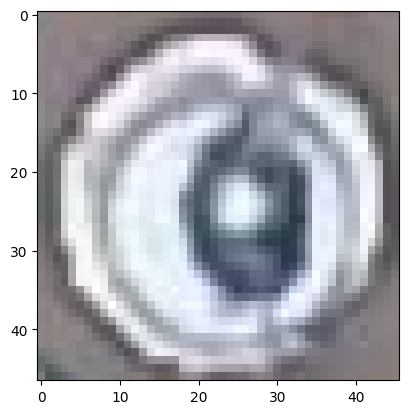

Waiting for object...
Starting Cycle    29 -- CapMac -- add idle - sel0
Starting Cycle    30 -- CapMac -- add idle - sel0
Starting Cycle    31 -- CapMac -- add idle - sel0
Starting Cycle    32 -- CapMac -- add idle - sel0
Starting Cycle    33 -- CapMac -- add idle - sel0
Starting Cycle    34 -- CapMac -- add idle - sel0
Starting Cycle    35 -- CapMac -- add idle - sel0
Starting Cycle    36 -- CapMac -- add idle - sel0
Starting Cycle    37 -- CapMac -- add idle - sel0
Starting Cycle    38 -- CapMac -- add idle - sel0
Starting Cycle    39 -- CapMac -- add idle - sel0
Starting Cycle    40 -- CapMac -- add idle - sel0
Starting Cycle    41 -- CapMac -- add idle - sel0
Starting Cycle    42 -- CapMac -- add idle - sel0
Starting Cycle    43 -- CapMac -- add idle - sel0
Starting Cycle    44 -- CapMac -- add idle - sel0
Starting Cycle    45 -- CapMac -- add idle - sel0
Starting Cycle    46 -- CapMac -- add idle - sel0
Starting Cycle    47 -- CapMac -- add idle - sel0
Starting Cycle    48 -- CapM

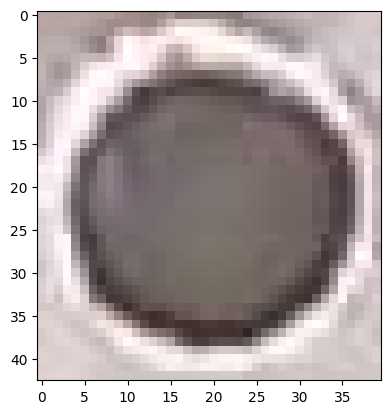

In [10]:
if __name__ == "__main__":
    for i in range(3):
        cm.cc.capture()
    for i in range(2):
        print("Waiting for object...")
        obj = cm.cycleForAddition()
        cm.annotateObject(obj.oid, f"Foo{i}", "Huntsman")
        plt.imshow(obj.visual())
        plt.show()

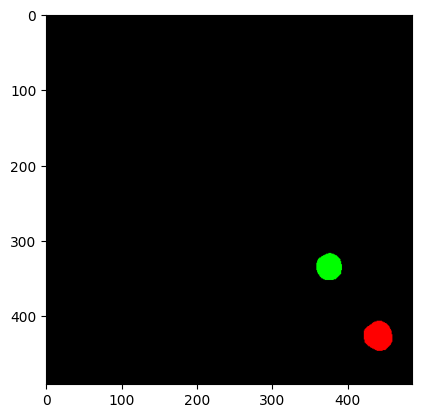

In [12]:
if __name__ == "__main__":
    plt.imshow(cm.buildMiniMap())
    plt.show()

In [ ]:
if __name__ == "__main__" and False:
    for i in range(2):
        print("Waiting for movement")
        obj = cm.cycleForMove()
        plt.imshow(obj.visual())
        plt.show()

In [ ]:
if __name__ == "__main__":
    lastMem = cm.cycleForAction()
    obj = lastMem['actedOn']
    print(obj.actionHistory)
    plt.imshow(obj.visual())
    plt.show()